# Exploratory data analysis of Auckland rainfall data


In this notebook, I am applying EDA methods to analyse rainfall data in Auckland between 1872 and 1997 and summarise the main characteristics. 

A set of tables was taken from the Auckland Council website: 
<a href="https://environmentauckland.org.nz/Data/DataSet/Summary/Location/A64871M/DataSet/Rainfall/Continuous/Interval/Latest">Link to Website</a> Five tables contain the daily amount of rainfall  in millimetres, measured at two different locations: Mt Albert and City centre. The tables cover various time intervals starting from 6 years to 140 years, and they include both measured values and synthesized data. 

We will explore here one of the data files, A64871M, covering a period between 1872 and 1997. The table is named AucklandRainfall1872-1997.csv, and it contains five columns and 31652 rows, but only two columns are needed for our analysis:  dates and the amount of rain in millimeters. The dates are given for NZST (UTC +12h) time zone. The frequency of the measurements is between 1 and 10 days. 

### 1. Importing Python libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from dateutil import tz
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

#setting default seaborn settings
sns.set()

### 2. Reading input file

To read the rain data, we will use the Panda's function pd.read_csv(). 

In [3]:
#setting the file path and the file name
file = 'Data/AucklandRainfall1872-1997.csv'

#reading file into dataframe: rain, and setting date column  as an index column of Datetime type 
rain=pd.read_csv(file, skiprows=3, header=None,
                  names=['Date','rain_value', 'grade', 'interpol_type', 'event_timestamp'],
                  parse_dates=['Date'],
                  index_col='Date')

#printing the first lines of the dataframe
rain.head(5)

,rain_value,grade,interpol_type,event_timestamp
Date,,,,
1872-01-03,0.00,200,5,NaN
1872-01-04,3.81,200,5,NaN
1872-01-05,2.03,200,5,NaN
1872-01-09,0.00,200,5,NaN
1872-01-10,0.51,200,5,NaN


### 3. Removing unnecessary columns

Three columns: grade, interpol_type, and event_timestamp have the same values throughout the table. At this stage of the analysis, we can remove them from the table. 

In [4]:
#counting unique values for three columns
display(rain['grade'].value_counts(sort=True, normalize=True))
display(rain['interpol_type'].value_counts(sort=True, normalize=True))
display(rain['event_timestamp'].value_counts(sort=True, normalize=True))

#dropping columns     
rain=rain.drop(columns=['event_timestamp', 'grade', 'interpol_type'])

200    1.0
Name: grade, dtype: float64

5    1.0
Name: interpol_type, dtype: float64

Series([], Name: event_timestamp, dtype: float64)

### 4. Displaying remaining columns

In [5]:
rain.info()
rain.tail(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31652 entries, 1872-01-03 00:00:00 to 1997-09-30 08:30:00
Data columns (total 1 columns):
rain_value    31652 non-null float64
dtypes: float64(1)
memory usage: 494.6 KB


,rain_value
Date,
1997-09-24 08:30:00,63.4
1997-09-25 08:30:00,15.0
1997-09-26 08:30:00,0.4
1997-09-29 08:30:00,80.2
1997-09-30 08:30:00,19.3


### 5. Exploring Date column

The Date column was not set to include a timezone. We will set a time zone for the DateTime index column relative to the UTC time, by using the IANA database and dateutil library. The timezone database is updated regularly and includes daylight savings and other time zone changes, which are especially important when we are working with datasets spread over a long time period. By exploring the Date column, we can find that only one measurement was recorded per day and that on about 30% of days, the amount of rain was not documented. 

In [6]:
#checking if the data frame includes a timezone
rain.index.tzinfo

#creating a new data frame and setting the local timezone
rain_tz=rain.copy() 

#original date column saved as Date_naive
rain_tz['Date_naive']=rain_tz.index

#setting timezone offset relative to UTC 
rain_tz=rain_tz.tz_localize(tz=tz.gettz('Pacific/Auckland'))
display(rain_tz.head(2))

#another way of finding the start and end date for the measurements 
print('Start date: ', min(rain_tz.index), 'End date: ', max(rain_tz.index))

#unique dates .vs. total number of dates:
print('Unique dates:', len(rain_tz.index.unique()), '.v.s. Total number of dates:', rain_tz.shape[0])

#number of days without measurements .vs. total number of days
delta=max(rain_tz.index)-min(rain_tz.index)
no_measurements=delta.days-rain_tz.shape[0]
print('Total number of days:', delta.days, '.vs. Number of days without measurements:',no_measurements, '--', round(no_measurements/delta.days*100, 0), ' %')

,rain_value,Date_naive
Date,,
1872-01-03 00:00:00+11:39:04,0.00,1872-01-03
1872-01-04 00:00:00+11:39:04,3.81,1872-01-04


Start date:  1872-01-03 00:00:00+11:39:04 End date:  1997-09-30 08:30:00+12:00
Unique dates: 31652 .v.s. Total number of dates: 31652
Total number of days: 45926 .vs. Number of days without measurements: 14274 -- 31.0  %


### 6. Exploring the rain_value column

By exploring the rain_value column we can find number of days with the zerro amount of rain and also the dates with the maximum rainfall. 

In [7]:
#counting the frequency of rain values
rain_days= rain_tz['rain_value'].value_counts(dropna=True, sort=True)

#number of days with 0 records .vs. total number of days
print('Number of days without rain:', rain_days[0], '---', round(rain_days[0]/rain_tz.shape[0] *100, 0),'%')

#dates with the maximum rainfalls:
rain_sorted=rain_tz.sort_values(by='rain_value', ascending=False)
display(rain_sorted.head(5))

Number of days without rain: 8473 --- 27.0 %


,rain_value,Date_naive
Date,,
1936-02-02 00:00:00+12:00,162.05,1936-02-02
1985-05-23 00:00:00+12:00,156.60,1985-05-23
1979-02-18 00:00:00+13:00,142.20,1979-02-18
1917-02-04 00:00:00+11:30,140.72,1917-02-04
1989-08-26 00:00:00+12:00,133.30,1989-08-26


### 7. Finding number of days with little rain

After excluding dates recorded as days with zero rain, we can find out how many days have rainfall less than 20 mm per day. 

In [8]:
#setting a constant for amount of rain per day in mm
rain_c=20

#sorting rain frequency dataframe (rain_days)
rain_sorted=rain_days.sort_index()

#selecting only values of rain between 0.1 and rain_c & summing number of days
days_no=rain_sorted[rain_sorted.index[1]:rain_c].values.sum()

#finding percentage of days with rain_c amount of rain
rain_perc=round(days_no/rain_tz.shape[0]*100, 0)

print('Number of days with rain less than', rain_c, ' mm/day:', days_no, '---', rain_perc, '%', '\n')

Number of days with rain less than 20  mm/day: 21512 --- 68.0 % 



### 8. Plotting all data

Python has several different libraries for plotting data. We will use the Matplotlib library and Pandas built-in function .plot() for plotting rain DataFrame. 

Text(0.5, 1.0, 'Rainfall in Auckland between 1872 and 1997')

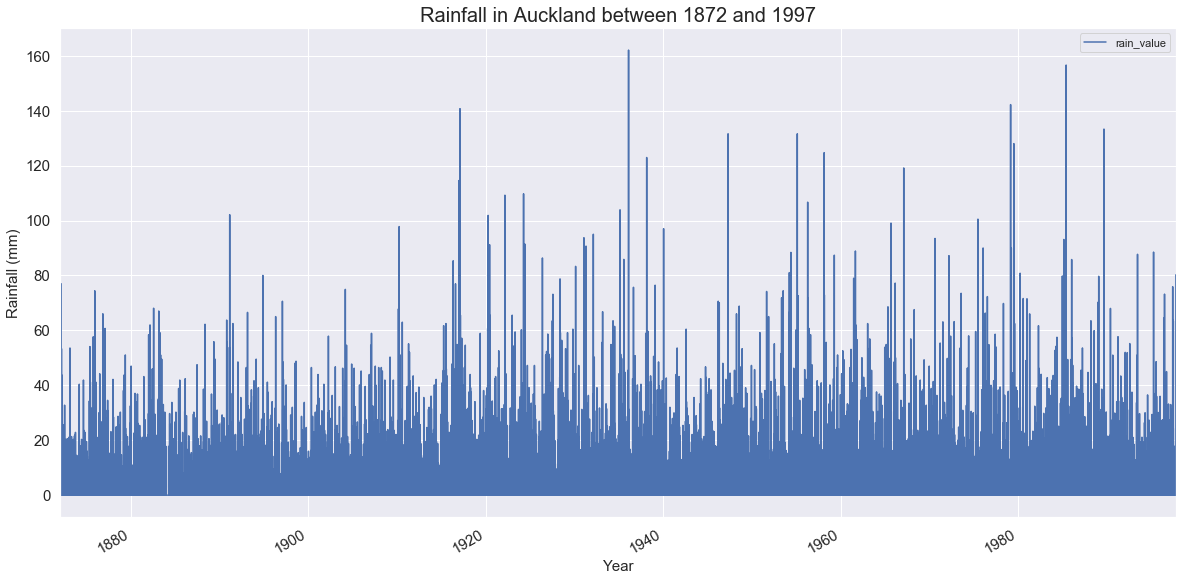

In [9]:
rain.plot(figsize=(20,10), fontsize=15)
#setting xlabel, ylabel and title
plt.xlabel('Year', fontsize=15)
plt.ylabel('Rainfall (mm)', fontsize=15)
plt.title('Rainfall in Auckland between 1872 and 1997', fontsize=20)

### 9. Plotting three different time intervals

We will plot three selected intervals, each two years long, from the start of the data set, middle, and the end of the file. If we assume that all rain values were collected in the same way and that all zero points represent days without rain, then we can expect to see seasonal changes across a year plus variations from year to year. 

Text(0.5, 1.0, 'Auckland rainfall')

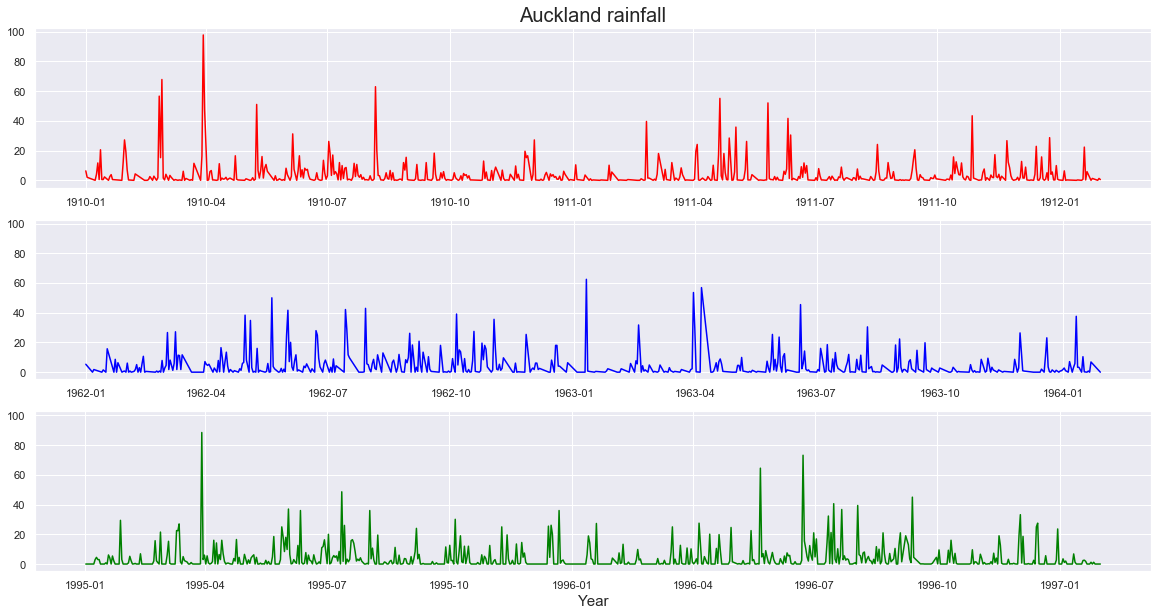

In [10]:
#selecting various time intervals from the rain dataframe
rain_1012=rain['1910-01': '1912-01']
rain_6264=rain['1962-01': '1964-01']
rain_9597=rain['1995-01': '1997-01']

#plotting rain values for three intervals using plt.subplots()
fig,ax=plt.subplots(3,1, figsize=(20,10), sharey=True)
ax[0].plot(rain_1012.index, rain_1012['rain_value'], color='red')
ax[1].plot(rain_6264.index, rain_6264['rain_value'], color='blue')
ax[2].plot(rain_9597.index, rain_9597['rain_value'], color='green')

ax[2].set_xlabel('Year', fontsize=15)
ax[0].set_title('Auckland rainfall', fontsize=20)

### 9. Resampling Data

To see patterns and trends in data, we can resample data to the mean monthly, weekly, or annual values. From the plot, we can notice low rainfall values between 1912 and 1916. This can be because of missing data or because of the real low values of rainfall during that period. 

            rain_value
Date                  
1872-01-03        0.00
1872-01-04        3.81
1872-01-05        2.03
1872-01-09        0.00
1872-01-10        0.51
            rain_value
Date                  
1872-12-31    4.456820
1873-12-31    4.429283
1874-12-31    3.863617
1875-12-31    4.938923
1876-12-31    4.053715


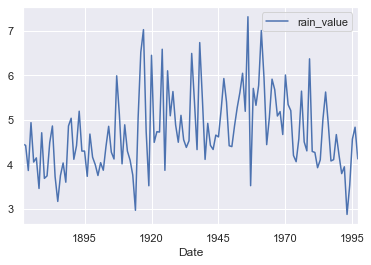

In [55]:
# Resample the data to the average monthly values
rain_annual = rain.resample("A").mean()

# Print the head of data
print(rain.head())

# Print the head of resampled data
print(rain_annual.head())

# Plot the data from 1910 to 1920
rain_annual.plot()

### 10. Exploring missing data

In general, we can explore whether the missing values for the rainfall are distributed evenly across the file, or they are more associated with a specific period. We will do that later, but for now, we will plot days with and without measurement between 1910 and 1920. We will create a new column named 'missing' and assign negative values for the rainfall.

,rain_value,missing
1912-01-01,NaN,-10.0
1912-01-02,NaN,-10.0
1912-01-03,0.00,NaN
1912-01-04,6.35,NaN
1912-01-05,0.00,NaN


,rain_value
Date,
1912-12-31,4.095805
1913-12-31,3.761473
1914-12-31,2.970165
1915-12-31,5.046135
1916-12-31,6.521008


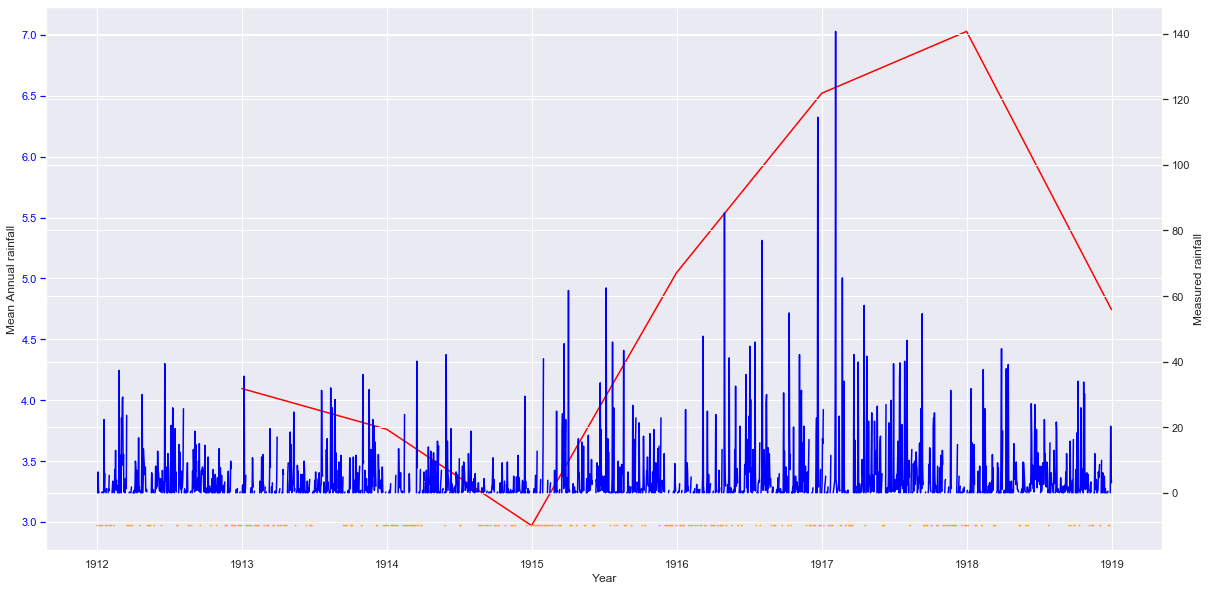

In [56]:
#resampling/reindexing daily data
rn=pd.date_range(start=min(rain.index), end=max(rain.index))
rain1=rain.reindex(rn).fillna(-10)

#creating two columns and assigning -10 to missing data
rain1['missing']=rain1[rain1.rain_value==-10]
rain1['rain_value']=rain1[rain1.rain_value!=-10]
rain1=rain1['1912':'1918']
rain_annual=rain_annual['1912':'1918']

#displaying resampled data
display(rain1.head(5))
display(rain_annual.head(5))

#plotting
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(rain_annual.index, rain_annual['rain_value'], color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Annual rainfall')
ax.tick_params('y', colors='blue')

ax1=ax.twinx()
ax1.plot(rain1.index, rain1['rain_value'], color='blue')
ax1.plot(rain1.index, rain1['missing'], color='orange')
ax1.set_ylabel('Measured rainfall')
plt.show()
